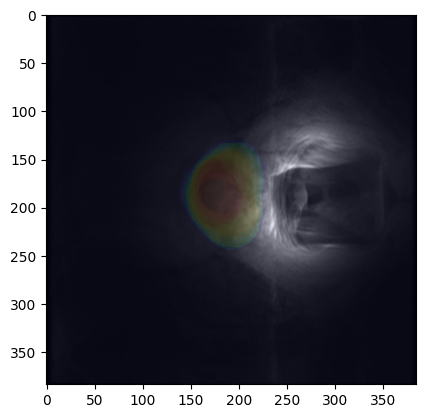

In [9]:
# import the .nii file
import nibabel as nib

import matplotlib.pyplot as plt
# now read in the image
segmentation = nib.load('./data/BIDMC/processed/Case02_segmentation.nii')
img = nib.load('./data/BIDMC/processed/Case02.nii')
# Compute the Z projection by summing along the Z-axis
z_projection = img.get_fdata().sum(axis=2)
seg_projection = segmentation.get_fdata().sum(axis=2)

# Display the Z projection
plt.imshow(z_projection, cmap='gray')
plt.imshow(seg_projection, alpha=0.1, cmap='jet')

In [10]:
# %%
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.nn.functional as F

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [11]:
import importlib
from distutils.version import LooseVersion

# check that all packages are installed (see requirements.txt file)
required_packages = {
    "jupyter",
    "numpy",
    "matplotlib",
    "ipywidgets",
    "scipy",
    "pandas",
    "numba",
    "multiprocess",
    "SimpleITK",
}

problem_packages = list()
# Iterate over the required packages: If the package is not installed
# ignore the exception.
for package in required_packages:
    try:
        p = importlib.import_module(package)
    except ImportError:
        problem_packages.append(package)

if len(problem_packages) == 0:
    print("All is well.")
else:
    print(
        "The following packages are required but not installed: "
        + ", ".join(problem_packages)
    )

All is well.


In [12]:
class MedicalImageDataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        
        # Convert to PyTorch tensors
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).float()
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
            
        return image, mask

In [13]:
import os
import glob
import numpy as np
import SimpleITK as sitk

def resample_image(image, target_size=(256, 256), is_mask=False):
    # Get current image size
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    
    # Calculate new spacing to fit target size
    new_size = [target_size[0], target_size[1], original_size[2]]
    new_spacing = [
        original_spacing[0] * original_size[0] / new_size[0],
        original_spacing[1] * original_size[1] / new_size[1],
        original_spacing[2]
    ]
    
    # Set interpolator
    interpolator = sitk.sitkNearestNeighbor if is_mask else sitk.sitkLinear
    
    resample = sitk.ResampleImageFilter()
    resample.SetSize(new_size)
    resample.SetOutputSpacing(new_spacing)
    resample.SetOutputOrigin(image.GetOrigin())
    resample.SetOutputDirection(image.GetDirection())
    resample.SetInterpolator(interpolator)
    
    return resample.Execute(image)

def normalize_image(img_slice):
    # Normalize to [0,1], avoid divide by zero
    min_val = np.min(img_slice)
    max_val = np.max(img_slice)
    if max_val - min_val > 1e-5:
        return (img_slice - min_val) / (max_val - min_val)
    else:
        return np.zeros_like(img_slice)

def load_and_preprocess_data(data_dir='./data', target_size=(256, 256)):
    images = []
    masks = []
    for folder in glob.glob(os.path.join(data_dir, '*')):
        if not os.path.isdir(folder) or not os.path.exists(os.path.join(folder, 'processed')):
            continue
        img_files = glob.glob(os.path.join(folder, 'processed', 'Case*.nii'))
        for img_file in img_files:
            if '_segmentation' in img_file:
                continue
            case_id = os.path.basename(img_file).split('.')[0]
            seg_file = os.path.join(folder, 'processed', f"{case_id}_segmentation.nii")
            if os.path.exists(seg_file):
                print(f"Processing {img_file} and {seg_file}")
                # Read using SimpleITK
                sitk_img = sitk.ReadImage(img_file)
                sitk_seg = sitk.ReadImage(seg_file)
                
                # Optionally, resample both to target_size
                if target_size is not None:
                    sitk_img = resample_image(sitk_img, target_size=target_size, is_mask=False)
                    sitk_seg = resample_image(sitk_seg, target_size=target_size, is_mask=True)
                
                img_arr = sitk.GetArrayFromImage(sitk_img)  # shape: [slices, H, W]
                seg_arr = sitk.GetArrayFromImage(sitk_seg)
                
                # Iterate through slices
                for i in range(img_arr.shape[0]):
                    img_slice = img_arr[i]
                    seg_slice = seg_arr[i]
                    if np.max(seg_slice) > 0:
                        img_slice = normalize_image(img_slice)
                        seg_slice = (seg_slice > 0).astype(np.float32)  # Binarize if needed
                        images.append(img_slice)
                        masks.append(seg_slice)
    # Convert to numpy arrays
    images = np.array(images)
    masks = np.array(masks)
    # [N, H, W] -> [N, 1, H, W]
    images = np.expand_dims(images, axis=1)
    masks = np.expand_dims(masks, axis=1)
    return images.astype(np.float32), masks.astype(np.float32)

In [ ]:
# Load and preprocess the data
images, masks = load_and_preprocess_data()

images = images  # Limit to first 100 images for testing
masks = masks    # Limit to first 100 masks for testing


# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Create PyTorch datasets
train_dataset = MedicalImageDataset(X_train, y_train)
val_dataset = MedicalImageDataset(X_val, y_val)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Processing ./data\BIDMC\processed\Case00.nii and ./data\BIDMC\processed\Case00_segmentation.nii
Processing ./data\BIDMC\processed\Case02.nii and ./data\BIDMC\processed\Case02_segmentation.nii
Processing ./data\BIDMC\processed\Case03.nii and ./data\BIDMC\processed\Case03_segmentation.nii
Processing ./data\BIDMC\processed\Case04.nii and ./data\BIDMC\processed\Case04_segmentation.nii
Processing ./data\BIDMC\processed\Case05.nii and ./data\BIDMC\processed\Case05_segmentation.nii
Processing ./data\BIDMC\processed\Case06.nii and ./data\BIDMC\processed\Case06_segmentation.nii
Processing ./data\BIDMC\processed\Case07.nii and ./data\BIDMC\processed\Case07_segmentation.nii
Processing ./data\BIDMC\processed\Case08.nii and ./data\BIDMC\processed\Case08_segmentation.nii
Processing ./data\BIDMC\processed\Case09.nii and ./data\BIDMC\processed\Case09_segmentation.nii
Processing ./data\BIDMC\processed\Case10.nii and ./data\BIDMC\processed\Case10_segmentation.nii


(1, 256, 256)

In [ ]:
# %%
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        
        # Encoder (Contracting Path)
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.enc4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Bridge
        self.bridge = DoubleConv(512, 1024)
        
        # Decoder (Expanding Path)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec1 = DoubleConv(1024, 512)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = DoubleConv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec3 = DoubleConv(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec4 = DoubleConv(128, 64)
        
        # Output layer
        self.out = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bridge
        bridge = self.bridge(self.pool4(enc4))
        
        # Decoder with skip connections
        dec1 = self.dec1(torch.cat([self.up1(bridge), enc4], dim=1))
        dec2 = self.dec2(torch.cat([self.up2(dec1), enc3], dim=1))
        dec3 = self.dec3(torch.cat([self.up3(dec2), enc2], dim=1))
        dec4 = self.dec4(torch.cat([self.up4(dec3), enc1], dim=1))
        
        # Output
        out = torch.sigmoid(self.out(dec4))
        
        return out

# Initialize the model
model = UNet().to(device)
print(model)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

UNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )


In [20]:
# %%
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        
        with torch.no_grad():
            for images, masks in val_loader:
                images = images.to(device)
                masks = masks.to(device)
                
                outputs = model(images)
                val_loss = criterion(outputs, masks)
                
                running_val_loss += val_loss.item() * images.size(0)
        
        epoch_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
        
        # Save the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            torch.save(model.state_dict(), 'unet_model_best.pth')
            print(f'Model saved at epoch {epoch+1}')
    
    return train_losses, val_losses

# Train the model
num_epochs = 2
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
# now use the model to predict on images and generate masks
model.load_state_dict(torch.load('unet_model_best.pth'))

def predict(model, dataloader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            predictions.append(outputs.cpu().numpy())
    
    return np.concatenate(predictions, axis=0)

# Predict on validation set
predictions = predict(model, val_loader)
# Convert predictions to binary masks
predictions = (predictions > 0.5).astype(np.float32)
# Visualize some predictions

def visualize_predictions(images, masks, predictions, num_images=4):
    plt.figure(figsize=(14, 3 * num_images))
    
    for i in range(num_images):
        plt.subplot(num_images, 2, i * 3 + 1)
        plt.imshow(images[i, -1], cmap='gray')
        plt.title('Input Image')
        plt.axis('off')
        
        plt.subplot(num_images, 2, i * 3 + 2)
        plt.imshow(masks[i, -1], cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        plt.subplot(num_images, 2, i * 3 + 3)
        plt.imshow(predictions[i, -1], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    


NameError: name 'model' is not defined

In [13]:
# load the .npy files 
import numpy as np

unet_masks = np.load('./unet_masks.npy')
unet_outputs = np.load('./unet_outputs.npy')


In [14]:
visualize_predictions(unet_outputs, unet_masks, predictions, num_images=5)    

NameError: name 'visualize_predictions' is not defined